# Creating a profitable S&P500 trading algorithm

One of the most common pieces of stock trading advice is that 'you can't beat the market'; i.e. the market performs more efficiently than the average trader, and one is best off just investing in the stock market as a whole and seeling stock when capital is needed.  In this project, we are going to see if it is possible to use the historic prices of the stock market to generate a trading algorithm which will, on average, have a better rate of return than  a buy-and-hold strategy.

For this exercise, we are going to use this dataset of historic prices for the S&P500.  The data can be downloaded from this [link](https://www.kaggle.com/crescenzo/sp500/downloads/sp500.zip/1).  While the S&P500 index as whole cannot be traded, per se, there are many ETFs which closely mirror this, so we would expect any conclusions we make to carry over to those funds.

Let's go ahead and load in the modules we will want to be using.

In [1]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import math as math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier



In [2]:
data = pd.read_csv('S&P.csv')
print(data.shape)
data.head(10)

(15120, 7)


,Date,Open,High,Low,Close,Volume,Adj Close
0,2017-03-24,2350.419922,2356.219971,2335.739990,2343.979980,2975130000,2343.979980
1,2017-03-23,2345.969971,2358.919922,2342.129883,2345.959961,3260600000,2345.959961
2,2017-03-22,2343.000000,2351.810059,2336.449951,2348.449951,3572730000,2348.449951
3,2017-03-21,2379.320068,2381.929932,2341.899902,2344.020020,4265590000,2344.020020
4,2017-03-20,2378.239990,2379.550049,2369.659912,2373.469971,3054930000,2373.469971
5,2017-03-17,2383.709961,2385.709961,2377.639893,2378.250000,5178040000,2378.250000
6,2017-03-16,2387.709961,2388.100098,2377.179932,2381.379883,3365660000,2381.379883
7,2017-03-15,2370.340088,2390.010010,2368.939941,2385.260010,3906840000,2385.260010
8,2017-03-14,2368.550049,2368.550049,2358.179932,2365.449951,3172630000,2365.449951
9,2017-03-13,2371.560059,2374.419922,2368.520020,2373.469971,3133900000,2373.469971


Since the stock market in general goes up over time, let's see the S&P500's performance over time.

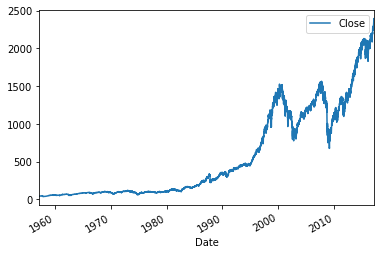

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date', ascending=False)
historic_plot = data.plot('Date', 'Close')

Let's baseline our algorithm with three naive strategies.  First, we will make a case where we just buy stock at a random point in time, and then sell it all at a future random point in time. Second, we will use the common consideration of holding the stock for at least two years, then selling at a random point in time.  Finally, we will do a long hold, of at least ten years, then a sale at a random point in time.  For each of these, will run 10000 randomized trials to see what the rate of return would have been on our stock purchase as a function of time.

For the purposes of this exercise, we will give ourselves 50,000 dollars to work with.

In [4]:
funds = 50000
def purch_price(index):
    open_price = data['Open'][index]
    close_price = data['Close'][index]
    price = round(random.uniform(min([open_price, close_price]), max([open_price, close_price])),2)
    return price

def ror(end_value, begin_value, years):
    ror = (((1 + (end_value-begin_value)/begin_value)**(1/years) -1)*100)
    return ror
    

def no_hold():
    buy_index = random.randint(1,len(data))
    buy_date = data['Date'][buy_index]
    buy_price = purch_price(buy_index)
    stocks_purchased = math.floor(funds/buy_price)
    funds_remaining = funds - stocks_purchased*buy_price
    sell_index = random.randint(0, buy_index)
    sell_date = data['Date'][sell_index]
    sell_price = purch_price(sell_index)
    total_value_sell = round(sell_price*stocks_purchased + funds_remaining,2)
    hold_years = (sell_date - buy_date).days / 365.25
    rate_of_return = ror(total_value_sell, funds, hold_years)
    return rate_of_return, buy_date, sell_date, round(hold_years,1)

def two_year_hold():
    buy_index = random.randint(505,len(data))
    buy_date = data['Date'][buy_index]
    buy_price = purch_price(buy_index)
    stocks_purchased = math.floor(funds/buy_price)
    funds_remaining = funds - stocks_purchased*buy_price
    sell_index = random.randint(0, buy_index-504)
    sell_date = data['Date'][sell_index]
    sell_price = purch_price(sell_index)
    total_value_sell = round(sell_price*stocks_purchased + funds_remaining,2)
    hold_years = (sell_date - buy_date).days / 365.25
    rate_of_return = ror(total_value_sell, funds, hold_years)
    return rate_of_return, buy_date, sell_date, round(hold_years,1)

def ten_year_hold():
    buy_index = random.randint(2516,len(data))
    buy_date = data['Date'][buy_index]
    buy_price = purch_price(buy_index)
    stocks_purchased = math.floor(funds/buy_price)
    funds_remaining = funds - stocks_purchased*buy_price
    sell_index = random.randint(0, buy_index-2515)
    sell_date = data['Date'][sell_index]
    sell_price = purch_price(sell_index)
    total_value_sell = round(sell_price*stocks_purchased + funds_remaining,2)
    hold_years = (sell_date - buy_date).days / 365.25
    rate_of_return = ror(total_value_sell, funds, hold_years)
    return rate_of_return, buy_date, sell_date, round(hold_years,1)

def sell_next_day():
    buy_index = random.randint(1,len(data))
    buy_date = data['Date'][buy_index]
    buy_price = purch_price(buy_index)
    stocks_purchased = math.floor(funds/buy_price)
    funds_remaining = funds - stocks_purchased*buy_price
    sell_index = buy_index - 1
    sell_date = data['Date'][sell_index]
    sell_price = purch_price(sell_index)
    total_value_sell = round(sell_price*stocks_purchased + funds_remaining,2)
    hold_years = (sell_date - buy_date).days / 365.25
    rate_of_return = ror(total_value_sell, funds, hold_years)
    return rate_of_return, buy_date, sell_date, round(hold_years,1)

def plot_ror(hold_type, runs = len(data)*5, x_axis = 'Buy Date'):
    buy_dates = []
    ror_list = []
    sell_dates = []
    hold_times = []
    count = 0
    while count < runs:
        ror, buy_date, sell_date, hold_years = hold_type()
        buy_dates.append(buy_date)
        sell_dates.append(sell_date)
        ror_list.append(ror)
        hold_times.append(hold_years)
        count += 1
    
    df = pd.DataFrame({'Buy Date': buy_dates, 'Rate of Return': ror_list, 'Sell Date': sell_dates, 'Hold Time': hold_times})
    df.sort_values('Buy Date', ascending=True)
    daily_avg_ror = []
    dates_unique = df[x_axis].unique()
    for i in dates_unique:
            avg_ror = df[df[x_axis] == i]['Rate of Return'].median()
            daily_avg_ror.append(avg_ror)
    daily_avg_ror = pd.DataFrame({x_axis: dates_unique, 'Daily Average Rate of Return': daily_avg_ror})
    df = df.merge(daily_avg_ror, how='left', on=x_axis)
    df.plot(x_axis, 'Daily Average Rate of Return')
    if hold_type == no_hold:
        plt.title('Rate of Return vs. Time For No Minimum Hold Stock Sale')
        plt.ylim(-30, 35)
    elif hold_type == two_year_hold:
        plt.title('Rate of Return vs. Time For Two-Year Minimum Hold Stock Sale')
        plt.ylim(-20, 25)
    elif hold_type == sell_next_day:
        plt.title('Rate of Return vs. Time For Sell Next Day Sale')
        plt.ylim(-101, 75000)
    elif hold_type == ten_year_hold:
        plt.title('Rate of Return vs. Time For Ten-Year Minimum Hold Stock Sale')
        plt.ylim(-15, 20)
    else:
        plt.title('Rate of Return vs. Time')
        plt.ylim(df['Daily Average Rate of Return'].min()*.95, df['Daily Average Rate of Return'].max()*1.05)
    plt.show()

def average_return(hold_type, runs = len(data)*15):
    count = 0
    rors = []
    while count < runs:
        rors.append(hold_type()[0])
        count += 1
    avg = round(np.median(rors), 2)
    if hold_type == no_hold:
        j = 'No Minimum Hold'
    elif hold_type == two_year_hold:
        j = '2 Year Minimum Hold'
    elif hold_type == ten_year_hold:
        j = '10 Year Minimum Hold'
    elif hold_type == sell_next_day:
        j = 'Sell Next Day'
    else:
        j = 'strategy of this type'
    print('For a 'f'{j}' ' sale, the average return is 'f'{avg}')
    return avg

    

For a Sell Next Day sale, the average return is 10.12


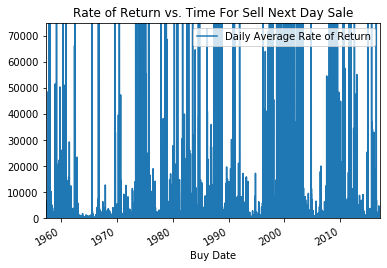

For a No Minimum Hold sale, the average return is 7.18


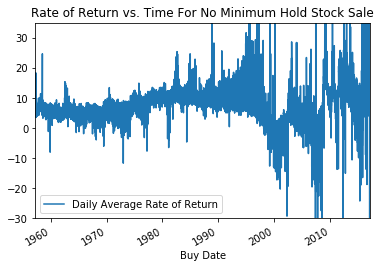

For a 2 Year Minimum Hold sale, the average return is 7.12


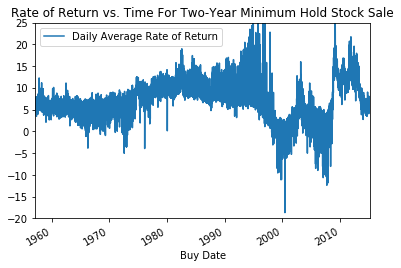

For a 10 Year Minimum Hold sale, the average return is 6.9


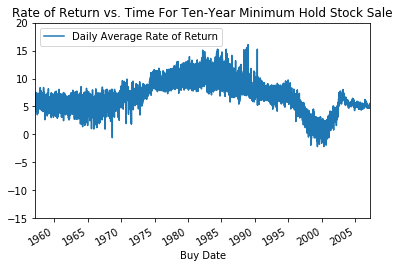

In [5]:
holding_strategies = [sell_next_day, no_hold, two_year_hold, ten_year_hold]
for i in holding_strategies:
    average_return(i)
    plot_ror(i)


We see that the average return on any given sale reduces the longer hold time we enforce, but the noise, and therefore the risk of the sale reduces.  Whats important to note, however, is that this analysis doesn't necessarily represent reality. It assumes that we always have the same a mount of money to invest, no matter the previous performance of the market, and so this doesn't imply that we should employ a 'sell next day strategy'. This also neglects any transaction fees, and  taxes (which could be quite substantial).

The other thing that is apparent is important it is when one chooses to buy the stock and, we'll see in the next cell, when to sell it.

This is what is generally referred to as "timing the market" and most general [investment advice](https://www.forbes.com/sites/simonmoore/2016/03/07/the-myth-of-market-timing/#6f8b783c461e) cautions against it, citing research that lay people are generally unsuccessful in their attempts 

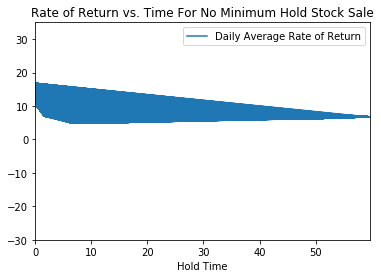

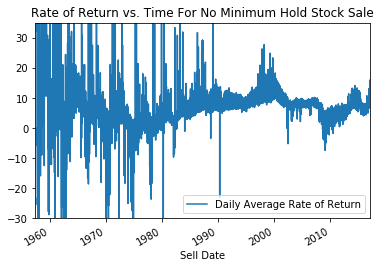

In [6]:
plot_ror(no_hold, runs=150000, x_axis='Hold Time')
plot_ror(no_hold, runs=150000, x_axis='Sell Date')

So while timing the market is hard, there are clearly better and worse times to buy and sell stock. The difficulty is not that timing the market wouldn't work, the problem is that it is very difficult to do *well*.

We are going to apply some machine learning algorithms to see if we can use data to help us get a better rate of return than the ~7% we get by not trying.

Lets begin by adding some simple statistical features to our data that we expect to be handly later.

In [7]:
data['Median'] = (data['High'] + data['Low']) /2
# data['Range'] = data['High'] - data['Low']
# data['Open Dist to Low'] = data['Open'] - data['Low']
# data['Open Dist to High'] = data['High'] - data['Open']
# data['Close Dist to Low'] = data['Close'] - data['Low']
# data['Close Dist to High'] = data['High'] - data['Close']
# data['Change in Day'] = data['Close'] - data['Open']

data.tail(10)

,Date,Open,High,Low,Close,Volume,Adj Close,Median
15110,1957-03-15,44.049999,44.049999,44.049999,44.049999,1600000,44.049999,44.049999
15111,1957-03-14,44.070000,44.070000,44.070000,44.070000,1580000,44.070000,44.070000
15112,1957-03-13,44.040001,44.040001,44.040001,44.040001,1840000,44.040001,44.040001
15113,1957-03-12,43.750000,43.750000,43.750000,43.750000,1600000,43.750000,43.750000
15114,1957-03-11,43.779999,43.779999,43.779999,43.779999,1650000,43.779999,43.779999
15115,1957-03-08,44.070000,44.070000,44.070000,44.070000,1630000,44.070000,44.070000
15116,1957-03-07,44.209999,44.209999,44.209999,44.209999,1830000,44.209999,44.209999
15117,1957-03-06,44.230000,44.230000,44.230000,44.230000,1840000,44.230000,44.230000
15118,1957-03-05,44.220001,44.220001,44.220001,44.220001,1860000,44.220001,44.220001
15119,1957-03-04,44.060001,44.060001,44.060001,44.060001,1890000,44.060001,44.060001


Now, let's lets think about what trading decisions we would have made with perfect foresight.  First, we will assume that we are buying or selling stock at some random point in the current day; we don't have information to guess when the high or low will be, so we will have to buy/sell somewhere in the middle. For this, we will use the median.  Next, we need to come up with a few different "perfect" strategies, accounting for potential uncertainty in our model.  We will make a purchase decision every day, according to these schemes.

1.  Buy or Sell.  If the median of the current day is higher than the median of the previous day, we will assume we should sell (or buy, for the inverse).

2. Buy, Sell, or hold.  We will try to account for uncertainy of price at the time of the transaction on the current day.  If the low for current day is greater than the high for the previous day, we will sell.  If the current high is lower than the previous low, we will buy.  If neither condition is true, we will make no purchase.

3. Large Buy, Buy, Large Sell, Sell, or hold.  This condition is the same as the previous, except we will add weights to how much we would like to buy or sell, depending on the degree to which the price moved.

In [8]:
# cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Open Dist to Low', 'Open Dist to High', 'Close Dist to Low', 'Close Dist to High', 'Change in Day']
# for i coll

In [9]:
data['Buy or Sell'] = 'Sell'
data['median difference'] = data['Median'].diff().fillna(0)
data.loc[data['median difference'] < 0, 'Buy or Sell'] = 'Buy'

data['Buy, Sell, Hold'] = 'Hold'
data.loc[data['Low'] > data['High'].shift(1),'Buy, Sell, Hold'] = 'Sell'
data.loc[data['High'] < data['Low'].shift(1), 'Buy, Sell, Hold'] = 'Buy'

data['Large Buy, Buy, Large Sell, Sell, Hold'] = 'Hold'
data.loc[data['Low'] > (data['High'].shift(1)), 'Large Buy, Buy, Large Sell, Sell, Hold'] = 'Sell'
data.loc[data['Low'] > (data['High'].shift(1) + (1*data['High'] - data['Low'])),'Large Buy, Buy, Large Sell, Sell, Hold'] = 'Large Sell'
data.loc[data['High'] < (data['Low'].shift(1)),'Large Buy, Buy, Large Sell, Sell, Hold'] = 'Buy'
data.loc[data['High'] < (data['Low'].shift(1) - (1*data['High'] - data['Low'])),'Large Buy, Buy, Large Sell, Sell, Hold'] = 'Large Buy'


# if test['median difference'] >= 0:
#     test['Buy or Sell'] = 'Buy'
# else:
#     test['Buy or Sell'] = 'Sell'
# test.head(30)
# if test['Median'] <= test['Median'].shift(-1):
#     test['Buy or Sell'] = 'Buy'
# else:
#     test['Buy or Sell'] = 'Sell'
    
# test.head(30)
# for index, row in data.iterrows():
#     if index > 0:
#         if row['Median'] >= data['Median'][index-1]:
#             data['Buy or Sell'][index] = 'Sell'
#         else:
#             data['Buy or Sell'][index] = 'Buy'
#     else:
#         data['Buy or Sell'][index] = 'Buy'
        
# data['Buy, Sell, Hold'] = 0
# for index, row in data.iterrows():
#     if index > 0:
#         if row['Low'] >= data['High'][index-1]:
#             data['Buy, Sell, Hold'][index] = 'Sell'
#         elif row['High'] <= data['Low'][index-1]:
#             data['Buy, Sell, Hold'][index] = 'Buy'
#         else:
#             data['Buy, Sell, Hold'][index] = 'Hold'
#     else:
#         data['Buy, Sell, Hold'][index] = 'Hold'
        
# data['Large Buy, Buy, Large Sell, Sell, Hold'] = 0
# for index, row in data.iterrows():
#     if index > 0:
#         if row['Low'] >= data['High'][index-1] + 2*data['Range'][index]:
#             data['Large Buy, Buy, Large Sell, Sell, Hold'][index] = 'Large Sell'
#         elif row['Low'] >= data['High'][index-1]:
#             data['Large Buy, Buy, Large Sell, Sell, Hold'][index] = 'Sell'
#         elif row['High'] <= data['Low'][index-1] - 2*data['Range'][index]:
#             data['Large Buy, Buy, Large Sell, Sell, Hold'][index] = 'Large Buy'
#         elif row['High'] <= data['Low'][index-1]:
#             data['Large Buy, Buy, Large Sell, Sell, Hold'][index] = 'Buy'
#         else:
#             data['Large Buy, Buy, Large Sell, Sell, Hold'][index] = 'Hold'
#     else:
#         data['Large Buy, Buy, Large Sell, Sell, Hold'][index] = 'Hold'
        
data.head(15)

,Date,Open,High,Low,Close,Volume,Adj Close,Median,Buy or Sell,median difference,"Buy, Sell, Hold","Large Buy, Buy, Large Sell, Sell, Hold"
0,2017-03-24,2350.419922,2356.219971,2335.739990,2343.979980,2975130000,2343.979980,2345.979981,Sell,0.000000,Hold,Hold
1,2017-03-23,2345.969971,2358.919922,2342.129883,2345.959961,3260600000,2345.959961,2350.524902,Sell,4.544922,Hold,Hold
2,2017-03-22,2343.000000,2351.810059,2336.449951,2348.449951,3572730000,2348.449951,2344.130005,Buy,-6.394897,Hold,Hold
3,2017-03-21,2379.320068,2381.929932,2341.899902,2344.020020,4265590000,2344.020020,2361.914917,Sell,17.784912,Hold,Hold
4,2017-03-20,2378.239990,2379.550049,2369.659912,2373.469971,3054930000,2373.469971,2374.604981,Sell,12.690064,Hold,Hold
5,2017-03-17,2383.709961,2385.709961,2377.639893,2378.250000,5178040000,2378.250000,2381.674927,Sell,7.069946,Hold,Hold
6,2017-03-16,2387.709961,2388.100098,2377.179932,2381.379883,3365660000,2381.379883,2382.640015,Sell,0.965088,Hold,Hold
7,2017-03-15,2370.340088,2390.010010,2368.939941,2385.260010,3906840000,2385.260010,2379.474976,Buy,-3.165039,Hold,Hold
8,2017-03-14,2368.550049,2368.550049,2358.179932,2365.449951,3172630000,2365.449951,2363.364991,Buy,-16.109985,Buy,Buy
9,2017-03-13,2371.560059,2374.419922,2368.520020,2373.469971,3133900000,2373.469971,2371.469971,Sell,8.104980,Hold,Hold


In [10]:
list = ['Buy or Sell', 'Buy, Sell, Hold', 'Large Buy, Buy, Large Sell, Sell, Hold']
for i in list:
    print(data[i].value_counts())

Buy     8059
Sell    7061
Name: Buy or Sell, dtype: int64
Hold    13694
Buy       820
Sell      606
Name: Buy, Sell, Hold, dtype: int64
Hold          13694
Large Buy       679
Large Sell      542
Buy             141
Sell             64
Name: Large Buy, Buy, Large Sell, Sell, Hold, dtype: int64


It looks like if we use these conditions for being able to hold, we will hold ~ 90% of the time. Let's write a quick function which executes these orders each day, to see where we would be the most profitable.  When we have an order we are going to sell 3/4 of our stock, or spend 3/4 of our money (so it's always possible for us to make a purchase or sale). This parameter could be further optimized, but that's outside the scope of this study.

We will being with defining the buy_or_sell function, and see how it compares with a traditional buy and hold strategy.

In [11]:
def buy_or_sell():
    funds = 50000
    stocks = 0
    chrono_data = data.sort_values('Date', ascending=True)
    values = []
#     return chrono_data['Buy or Sell'].value_counts()
    for index, row in chrono_data.iterrows():
        if row['Buy or Sell'] == 'Buy':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_bought = math.floor(funds*(0.75) / price)
            stocks = stocks + stocks_bought
            stock_value = stocks*price
            funds = funds - (price * stocks_bought)
            total_value = funds + stock_value
            values.append(total_value)
        if row['Buy or Sell'] == 'Sell':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_sold = stocks*0.75
            stocks = stocks - stocks_sold
            stock_value = stocks*price
            funds = funds +stocks_sold*price
            total_value = funds + stock_value
            values.append(total_value)
    date_list = chrono_data['Date'].tolist()
    portfolio_value = pd.DataFrame({'Date': date_list, 'Portfolio_Value': values})
    return portfolio_value
    
buy_sell_value = buy_or_sell()
buy_sell_value['Log Portfolio'] = np.log10(buy_sell_value['Portfolio_Value'])
   
buy_sell_value.head(10)
        
            
            
        

,Date,Portfolio_Value,Log Portfolio
0,1957-03-04,50000.000000,4.698970
1,1957-03-05,50136.160000,4.700151
2,1957-03-06,50146.790000,4.700243
3,1957-03-07,50141.475000,4.700197
4,1957-03-08,50132.173750,4.700117
5,1957-03-11,50127.357031,4.700075
6,1957-03-12,50127.232461,4.700074
7,1957-03-13,50376.676641,4.702230
8,1957-03-14,50408.841211,4.702507
9,1957-03-15,50403.480449,4.702461


In [12]:
initial_purchase = math.floor(50000 / data['Close'].iloc[-1])
remainder = 50000 - initial_purchase*(data['Close'].iloc[-1])
hold_only = data
hold_only['hold_value'] = random.uniform(data['Low'], data['High'])*initial_purchase + remainder
buy_sell_value = buy_sell_value.merge(hold_only[['Date','hold_value']], how='left', on='Date')
buy_sell_value['Buy/Sell Ratio'] = np.log10(buy_sell_value['Portfolio_Value'] / buy_sell_value['hold_value'])

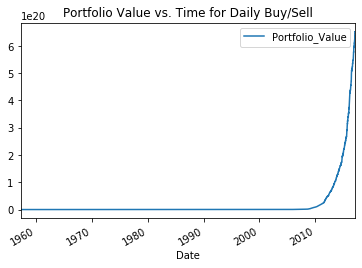

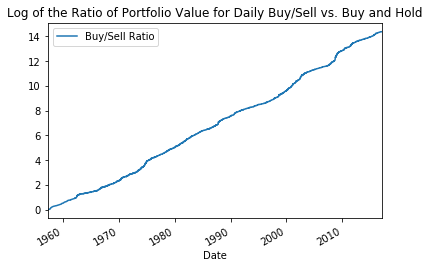

In [13]:
buy_sell_value.plot('Date','Portfolio_Value')
plt.title('Portfolio Value vs. Time for Daily Buy/Sell')
buy_sell_value.plot('Date', 'Buy/Sell Ratio')
plt.title('Log of the Ratio of Portfolio Value for Daily Buy/Sell vs. Buy and Hold')
plt.show()

We see that compared to buying and holding, our portfolio will grow immensely faster over tme if we are able to correctly predict whether we should have bought or sold each day.  This is no surprise, but let's check the rate of return on these transactions

In [14]:
def daily_buy_sell():
    init_index = random.randint(1,len(buy_sell_value))
    init_value = buy_sell_value['Portfolio_Value'][init_index]
    init_date = buy_sell_value['Date'][init_index]
    final_index = random.randint(0, init_index)
    final_value = buy_sell_value['Portfolio_Value'][final_index]
    final_date = buy_sell_value['Date'][final_index]
    years = (final_date - init_date).days/365.25
    rate_of_return = ror(final_value, init_value, years)
    return rate_of_return, init_date, final_date, round(years,2)
                                                  

C:\Users\willb\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


For a strategy of this type sale, the average return is 84.85
84.85


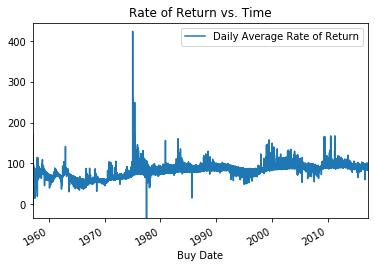

In [16]:

max_return = average_return(daily_buy_sell)
print(max_return)
plot_ror(daily_buy_sell)


So, rather than topping out around 7% for a buy and hold strategy, we average around 85% return if we can perfectly predict when to buy and when to sell. Furthermore, while there are still boom and bust times, we see that we can still make money at any point of the market's life. We also notice there are still a couple of instances where we lost a bit of money.  This is likely due to our enforcement of always buying and selling, yet there being uncertainty in the price.  We could have randomly bought at a high point or sold at a low point in the daily fluctuation, leading to a bit of lost money.

Let's similarly check the other two strategies and see how they would have performed.  Both of these will reduce risk associated with daily price fluctuations, but will likely have lower return overall due to their more conservative quality.

In [18]:
def buy_sell_hold():
    funds = 50000
    stocks = 0
    chrono_data = data.sort_values('Date', ascending=True)
    values = []
#     return chrono_data['Buy or Sell'].value_counts()
    for i in chrono_data['Buy, Sell, Hold']:
        if i == 'Buy':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_bought = math.floor(funds*(0.75) / price)
            stocks = stocks + stocks_bought
            stock_value = stocks*price
            funds = funds - (price * stocks_bought)
            total_value = funds + stock_value
            values.append(total_value)
        if i == 'Sell':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_sold = stocks*0.75
            stocks = stocks - stocks_sold
            stock_value = stocks*price
            funds = funds +stocks_sold*price
            total_value = funds + stock_value
            values.append(total_value)
        if i == 'Hold':
            price = round(random.uniform(row['Low'], row['High']),2)
            stock_value = stocks*price
            total_value = funds + stock_value
    date_list = chrono_data['Date'].tolist()
    portfolio_value = pd.DataFrame({'Date': date_list, 'Portfolio_Value': values})
    return portfolio_value

In [19]:
def graded_buy_sell_hold():
    funds = 50000
    stocks = 0
    chrono_data = data.sort_values('Date', ascending=True)
    values = []
#     return chrono_data['Buy or Sell'].value_counts()
    for index, row in chrono_data.iterrows():
        if row['Large Buy, Buy, Large Sell, Sell, Hold'] == 'Buy':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_bought = math.floor(funds*(0.25) / price)
            stocks = stocks + stocks_bought
            stock_value = stocks*price
            funds = funds - (price * stocks_bought)
            total_value = funds + stock_value
            values.append(total_value)
        if row['Large Buy, Buy, Large Sell, Sell, Hold'] == 'Large Buy':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_bought = math.floor(funds*(0.9) / price)
            stocks = stocks + stocks_bought
            stock_value = stocks*price
            funds = funds - (price * stocks_bought)
            total_value = funds + stock_value
            values.append(total_value)
        if row['Large Buy, Buy, Large Sell, Sell, Hold'] == 'Sell':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_sold = stocks*0.25
            stocks = stocks - stocks_sold
            stock_value = stocks*price
            funds = funds +stocks_sold*price
            total_value = funds + stock_value
            values.append(total_value)
        if row['Large Buy, Buy, Large Sell, Sell, Hold'] == 'Large Sell':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_sold = stocks*0.9
            stocks = stocks - stocks_sold
            stock_value = stocks*price
            funds = funds +stocks_sold*price
            total_value = funds + stock_value
            values.append(total_value)
        if row['Large Buy, Buy, Large Sell, Sell, Hold'] == 'Hold':
            price = round(random.uniform(row['Low'], row['High']),2)
            stock_value = stocks*price
            total_value = funds + stock_value
            values.append(total_value)
    date_list = chrono_data['Date'].tolist()
    portfolio_value = pd.DataFrame({'Date': date_list, 'Portfolio_Value': values})
    return portfolio_value

In [20]:
def buy_sell_hold():
    funds = 50000
    stocks = 0
    chrono_data = data.sort_values('Date', ascending=True)
    values = []
#     return chrono_data['Buy or Sell'].value_counts()
    for index, row in chrono_data.iterrows():
        if row['Buy, Sell, Hold'] == 'Buy':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_bought = math.floor(funds*(0.75) / price)
            stocks = stocks + stocks_bought
            stock_value = stocks*price
            funds = funds - (price * stocks_bought)
            total_value = funds + stock_value
            values.append(total_value)
        if row['Buy, Sell, Hold'] == 'Sell':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_sold = stocks*0.75
            stocks = stocks - stocks_sold
            stock_value = stocks*price
            funds = funds +stocks_sold*price
            total_value = funds + stock_value
            values.append(total_value)
        if row['Buy, Sell, Hold'] == 'Hold':
            price = round(random.uniform(row['Low'], row['High']),2)
            stock_value = stocks*price
            total_value = funds + stock_value
            values.append(total_value)
    date_list = chrono_data['Date'].tolist()
    portfolio_value = pd.DataFrame({'Date': date_list, 'Portfolio_Value': values})
    return portfolio_value

In [21]:
buy_sell_hold_value = buy_sell_hold()
graded_buy_sell_value = graded_buy_sell_hold()

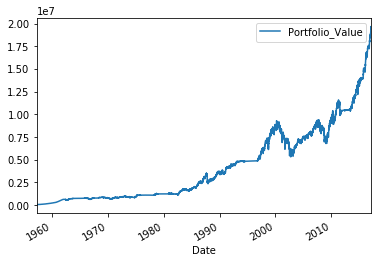

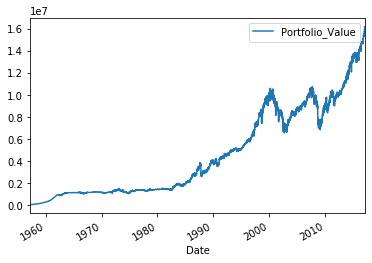

In [22]:
buy_sell_hold_value.plot('Date', 'Portfolio_Value')
graded_buy_sell_value.plot('Date', 'Portfolio_Value')

In [23]:
def single_buy_sell_hold():
    init_index = random.randint(1,len(buy_sell_hold_value))
    init_value = buy_sell_hold_value['Portfolio_Value'][init_index]
    init_date = buy_sell_hold_value['Date'][init_index]
    final_index = random.randint(0, init_index)
    final_value = buy_sell_hold_value['Portfolio_Value'][final_index]
    final_date = buy_sell_hold_value['Date'][final_index]
    years = (final_date - init_date).days/365.25
    rate_of_return = ror(final_value, init_value, years)
    return rate_of_return, init_date, final_date, round(years,2)

def single_graded_buy_sell_hold():
    init_index = random.randint(1,len(graded_buy_sell_value))
    init_value = graded_buy_sell_value['Portfolio_Value'][init_index]
    init_date = graded_buy_sell_value['Date'][init_index]
    final_index = random.randint(0, init_index)
    final_value = graded_buy_sell_value['Portfolio_Value'][final_index]
    final_date = graded_buy_sell_value['Date'][final_index]
    years = (final_date - init_date).days/365.25
    rate_of_return = ror(final_value, init_value, years)
    return rate_of_return, init_date, final_date, round(years,2)

For a strategy of this type sale, the average return is 7.15


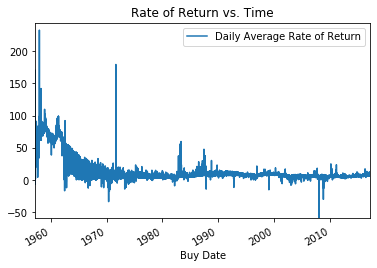

For a strategy of this type sale, the average return is 6.35


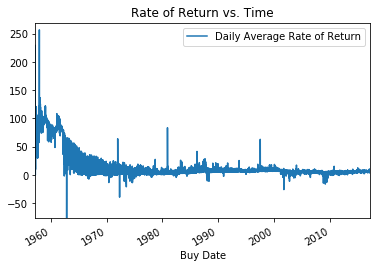

In [24]:

buy_sell_hold_return = average_return(single_buy_sell_hold)
plot_ror(single_buy_sell_hold)

graded_buy_sell_hold_return = average_return(single_graded_buy_sell_hold)
plot_ror(single_graded_buy_sell_hold)

So, we notice that with these strategies that include holds, we still have the possibility of losing money. This is because we can lose a little bit of money of successive days, if the drops aren't big enough. Still, this indicates that we probably want to purse a strategy where we make a decision where to buy or sell every trading day.

Since we have the buy/sell label, let us now see if we can make predictions about what that label should be, without any future information.  In this scenario, we are assuming that we will make the trade during the day, so we will have access to the opening price of our index, but not the low, high, close, or any other metric for the current day.  We do have all of the historic information though, so if there are any intelligible time trends, we want to be able to create features that will pick up on those trends, and be able to predict what will happen in time to make a good trade decision.

So, our next step is to create a bunch of possibly useful features in our dataset.  We will include things like ranges, std deviations, and price differences over different date ranges.  As these will be our features columns, we need to be very careful to not include any present day (except opening price) or future data, as this couldn't be replicated in a live trading scenario.

In [25]:
features = pd.DataFrame()
features['Date'] = data['Date']
data_rev = data.sort_values('Date', ascending=True)

In [26]:
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Median,Buy or Sell,median difference,"Buy, Sell, Hold","Large Buy, Buy, Large Sell, Sell, Hold",hold_value
0,2017-03-24,2350.419922,2356.219971,2335.739990,2343.979980,2975130000,2343.979980,2345.979981,Sell,0.000000,Hold,Hold,2.652542e+06
1,2017-03-23,2345.969971,2358.919922,2342.129883,2345.959961,3260600000,2345.959961,2350.524902,Sell,4.544922,Hold,Hold,2.657988e+06
2,2017-03-22,2343.000000,2351.810059,2336.449951,2348.449951,3572730000,2348.449951,2344.130005,Buy,-6.394897,Hold,Hold,2.661993e+06
3,2017-03-21,2379.320068,2381.929932,2341.899902,2344.020020,4265590000,2344.020020,2361.914917,Sell,17.784912,Hold,Hold,2.667274e+06
4,2017-03-20,2378.239990,2379.550049,2369.659912,2373.469971,3054930000,2373.469971,2374.604981,Sell,12.690064,Hold,Hold,2.695704e+06


In [27]:
print(data['Open'].rolling(1).mean().shift(-1))
print(data['Open'])

0        2345.969971
1        2343.000000
2        2379.320068
3        2378.239990
4        2383.709961
5        2387.709961
6        2370.340088
7        2368.550049
8        2371.560059
9        2372.520020
10       2363.489990
11       2369.810059
12       2370.739990
13       2375.229980
14       2380.919922
15       2394.750000
16       2380.129883
17       2366.080078
18       2365.229980
19       2355.729980
20       2367.500000
21       2361.110107
22       2354.909912
23       2343.010010
24       2349.639893
25       2335.580078
26       2326.120117
27       2321.719971
28       2312.270020
29       2296.699951
            ...     
15090      44.980000
15091      44.980000
15092      44.790001
15093      44.389999
15094      44.490002
15095      44.439999
15096      44.540001
15097      44.419998
15098      44.139999
15099      44.110001
15100      44.180000
15101      44.090000
15102      43.910000
15103      43.880001
15104      44.060001
15105      44.110001
15106      44

In [28]:
features['Close to Open'] = 0

features['Close to Open'] = (((data['Open'] - data['Close'].shift(-1))/data['Open']).fillna(0) * 100).copy()

history_list = [1,3,5,10,25,50,100,200,400]

for i in history_list:
    features['Change From 'f'{i} Trading Days Ago'] = (data['Open'].pct_change(-i).fillna(0)).copy()

for i in history_list:
    features['Std in Previous 'f'{i} Trading Days'] = ((data['Open'].rolling(i).std().shift(-(i-1))/data['Open']).fillna(0) *100).copy()
    
for i in history_list:
    features['Change From Mean of Previous 'f'{i} Trading Days'] = (((data['Open'] - data['Open'].rolling(i).mean().shift(-(i))) / data['Open']).fillna(1) *100).copy()
                                                                    
for i in history_list:
    features['Range of Previous 'f'{i} Trading Day'] = (((data['High'].shift(-i) - data['Low'].shift(-i)) / data['Open']).fillna(0) *100).copy()

for i in history_list:
    features['AVG Range of Previous 'f'{i} Trading Days'] = (((data['High'].rolling(i).mean().shift(-i) - data['Low'].rolling(i).mean().shift(-i)) / data['Open']).fillna(0) *100).copy()
    
for i in history_list:
    features['High Minus Low for Past 'f'{i} Trading Days'] = (((data['High'].rolling(i).max().shift(-(i)) - data['Low'].rolling(i).min().shift(-(i))) / data['Open']).fillna(0) * 100).copy()

for i in history_list:
    features['Average Close Minus Open for Past 'f'{i} Trading Days'] = ((((data['Close'] - data['Open']).rolling(i).mean().shift(-i)) / data['Open']).fillna(0) * 100).copy()
    
features.head()





,Date,Close to Open,Change From 1 Trading Days Ago,Change From 3 Trading Days Ago,Change From 5 Trading Days Ago,Change From 10 Trading Days Ago,Change From 25 Trading Days Ago,Change From 50 Trading Days Ago,Change From 100 Trading Days Ago,Change From 200 Trading Days Ago,...,High Minus Low for Past 400 Trading Days,Average Close Minus Open for Past 1 Trading Days,Average Close Minus Open for Past 3 Trading Days,Average Close Minus Open for Past 5 Trading Days,Average Close Minus Open for Past 10 Trading Days,Average Close Minus Open for Past 25 Trading Days,Average Close Minus Open for Past 50 Trading Days,Average Close Minus Open for Past 100 Trading Days,Average Close Minus Open for Past 200 Trading Days,Average Close Minus Open for Past 400 Trading Days
0,2017-03-24,0.189752,0.001897,-0.012146,-0.013966,-0.009315,0.000332,0.036066,0.102329,0.112514,...,25.139338,-0.000426,-0.423472,-0.341131,-0.138743,-0.012322,0.052884,0.061963,0.030626,0.022400
1,2017-03-23,-0.105712,0.001268,-0.013569,-0.017481,-0.007413,0.004449,0.033594,0.094172,0.111739,...,25.187023,0.232311,-0.491909,-0.395659,-0.133080,0.010980,0.052294,0.057387,0.031102,0.018087
2,2017-03-22,-0.043535,-0.015265,-0.017078,-0.011534,-0.011313,0.007257,0.030529,0.096412,0.115273,...,25.218950,-1.506617,-0.647745,-0.315324,-0.185660,0.021254,0.043705,0.056184,0.031809,0.015813
3,2017-03-21,0.245873,0.000454,-0.003514,0.004547,0.003619,0.024809,0.047633,0.106805,0.130818,...,24.833986,-0.200478,-0.232000,-0.039845,-0.044342,0.091253,0.077619,0.067405,0.037704,0.018748
4,2017-03-20,-0.000421,-0.002295,0.003333,0.002817,0.001267,0.028530,0.048524,0.106930,0.133732,...,24.845264,-0.229580,0.043868,0.016312,-0.023968,0.105759,0.082355,0.070632,0.040311,0.020597


Now we have created 55 features which we hope can capture some a bit of the time trends, if such thing exists.  Let's start by using a logistic regression model to see if we can learn anything there. In order to more closely simulate a real situation, we will make our training data anything before 2015, and test is everything after.

In [29]:
targets = data[['Date', 'Buy or Sell', 'Buy, Sell, Hold', 'Large Buy, Buy, Large Sell, Sell, Hold']]
model_data = features.merge(targets, how='left', on='Date')

train_data = model_data[model_data['Date'] < pd.to_datetime('2015-01-01')].copy()
test_data = model_data[model_data['Date'] >= pd.to_datetime('2015-01-01')].copy()

target1 = 'Buy or Sell'
target2 = 'Buy, Sell, Hold'
target3 = 'Large Buy, Buy, Large Sell, Sell, Hold'

X_train = train_data.drop(['Date', target1, target2, target3], axis=1).copy()
X_test = test_data.drop(['Date', target1, target2, target3], axis=1).copy()
y_train1= train_data[target1].copy()
y_train2= train_data[target2]
y_train3= train_data[target3]
y_test1= test_data[target1].copy()
y_test2= test_data[target2]
y_test3= test_data[target3]


In [30]:
logreg = LogisticRegression(solver='liblinear', multi_class='auto', class_weight='balanced')

def train_fit_model(estimator, X_train=X_train, y_train=y_train1, X_test=X_test, y_test=y_test1):
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_test)
    score = accuracy_score(y_test, predictions)
    print('The accuracy score for this model is 'f'{round(score,4)}')
    return score, predictions, estimator
          

In [31]:
train_fit_model(logreg)[0]
train_fit_model(logreg, y_train=y_train2, y_test=y_test2)[0]
train_fit_model(logreg, y_train=y_train3, y_test=y_test3)[0]

The accuracy score for this model is 0.5045
The accuracy score for this model is 0.9091
The accuracy score for this model is 0.9091


0.9090909090909091

So, our first swing with a logistic regression model returned 61% accuracy, which is better than the ~ 53% we would get just by assuming buy every time.  We'll do a featured selector and a limited grid search to see if we can do much better with this same estimator type.

We got a high accuracy for the options which inlcude a hold options.  Despite our intentional balanced weighing in the estimator, this is likely due to the fact that almost all instructions are to hold.  We will set these aside for now and focus on the buy/sell case.

In [32]:
rfecv= RFECV(logreg, cv=10)
rfecv.fit(X_train, y_train1)

RFECV(cv=10,
      estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='liblinear', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [33]:
best_features = X_train.columns[rfecv.support_]
X_train[best_features].head(10)

,Close to Open,Change From 5 Trading Days Ago,Change From 25 Trading Days Ago,Average Close Minus Open for Past 200 Trading Days
561,0.084530,0.000303,0.008252,0.042944
562,-0.099597,0.009283,0.015082,0.048597
563,-0.054614,0.012901,0.020412,0.046969
564,0.116114,0.032353,0.016157,0.040522
565,0.051846,0.055467,0.020461,0.041363
566,0.141243,0.047702,0.021189,0.038679
567,-0.066200,0.032044,0.014482,0.036503
568,-0.009216,0.015111,0.010705,0.034201
569,0.301636,-0.004408,-0.009211,0.025156
570,0.052186,-0.041329,-0.031611,0.015762


In [34]:
train_fit_model(logreg, X_train=X_train[best_features], X_test=X_test[best_features])[0]

The accuracy score for this model is 0.5205


0.5204991087344029

It looks like our model is performing nomnally better from doing our feature selection.  Let's try and tune the hyperparamaters to see if we can get further improvement.

In [35]:
params = {
    'C': [.0001, .001, .01, .1],
    'fit_intercept': [True, False],
    'class_weight' : [None, 'balanced'],
}
gssv = GridSearchCV(logreg, params, cv=10)
gssv.fit(X_train[best_features], y_train1)
gssv.best_params_

{'C': 0.01, 'class_weight': None, 'fit_intercept': True}

In [36]:
logreg2 = LogisticRegression(solver='liblinear', multi_class='auto', class_weight=None, fit_intercept=True, C=.01)
train_fit_model(logreg2, X_train=X_train[best_features], X_test=X_test[best_features])[0]

The accuracy score for this model is 0.5365


0.5365418894830659

We don't see any improvement through tuning the hyperparameters.  We want to see how our finances would have turned out had we used this model, but first, let's try a few more estimator types to see if we can do any better.

In [37]:
svm = SVC(gamma='auto')
train_fit_model(svm)[0]


The accuracy score for this model is 0.5169


0.5169340463458111

In [38]:
rf = RandomForestClassifier(n_estimators=10)
train_fit_model(rf)[0]

The accuracy score for this model is 0.4955


0.49554367201426025

In [39]:
mlp = MLPClassifier()
train_fit_model(mlp)[0]

The accuracy score for this model is 0.508


0.5080213903743316

The random forest and MLP models are promising enough that it's worth seeing if we can improve upon them.  I'll do some tuning behind the scenes, then we will choose our favorite model.

In [40]:
params = {
    'n_estimators': [100, 500, 1000],
    'criterion': ['entropy'],
    'max_depth' : [30],
    'min_samples_leaf' : [18]
}
gssv = GridSearchCV(rf, params, cv=5)
gssv.fit(X_train, y_train1)
gssv.best_score_

0.5196098633147881

In [41]:
gssv.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'min_samples_leaf': 18,
 'n_estimators': 100}

In [42]:
rf = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=30, min_samples_leaf=18)
train_fit_model(rf)[0]

The accuracy score for this model is 0.5169


0.5169340463458111

After some tuning, a random forest model is able to predict our test set at 59% accuracy, but this is still not as good as our simple logistic regression.

In [43]:
params = {
    'hidden_layer_sizes': [(2,2)],
    'activation': ['logistic'],
    'solver' : ['lbfgs'],
    'alpha' : [.1],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100000]
}
gssv = GridSearchCV(mlp, params, cv=3)
gssv.fit(X_train, y_train1)
gssv.best_score_

0.5330036403599149

In [44]:
gssv.best_params_

{'activation': 'logistic',
 'alpha': 0.1,
 'hidden_layer_sizes': (2, 2),
 'learning_rate': 'invscaling',
 'max_iter': 100000,
 'solver': 'lbfgs'}

In [45]:
mlp = MLPClassifier(hidden_layer_sizes=(2,2), activation='logistic', solver='lbfgs', alpha=0.1, learning_rate='constant', max_iter=100000)
train_fit_model(mlp)[0]

The accuracy score for this model is 0.5276


0.5276292335115864

We got a similar accuracy using MLP.  Given that the best accuracy was using the simple logistic regression model, and that will be the most interpretable, we will choose to go with that model.  What we want to do now is assign a buy/sell decision based on the results of the model.

In [46]:
test_data['Buy or Sell Model'] = train_fit_model(logreg)[1]

The accuracy score for this model is 0.5045


In [47]:
# test_data['Date'] = pd.to_datetime(test_data['Date'])
# test_data.info()
# test_data = test_data.merge(data, how='left', on='Date')
prediction_data = test_data.merge(hold_only, how='left', on='Date')
# data.info()
# hold_only.info()
prediction_data['Price'] = np.round(random.uniform(prediction_data['Low'], prediction_data['High']),2)
initial_purchase = math.floor(50000 / prediction_data['Price'].iloc[-1])
remainder = 50000 - initial_purchase*(prediction_data['Price'].iloc[-1])
prediction_data['hold_value'] = prediction_data['Price']*initial_purchase + remainder
prediction_data[['Date', 'Buy or Sell_x', 'Buy or Sell Model','Median', 'hold_value']].head(10)

,Date,Buy or Sell_x,Buy or Sell Model,Median,hold_value
0,2017-03-24,Sell,Buy,2345.979981,57075.68
1,2017-03-23,Sell,Sell,2350.524902,56981.60
2,2017-03-22,Buy,Buy,2344.130005,56672.96
3,2017-03-21,Sell,Buy,2361.914917,57558.80
4,2017-03-20,Sell,Buy,2374.604981,57471.92
5,2017-03-17,Sell,Buy,2381.674927,57615.68
6,2017-03-16,Sell,Sell,2382.640015,57632.24
7,2017-03-15,Buy,Buy,2379.474976,57463.52
8,2017-03-14,Buy,Sell,2363.364991,57134.72
9,2017-03-13,Sell,Buy,2371.469971,57440.48


In [48]:
prediction_data[['Date', 'Buy or Sell_x', 'Buy or Sell Model','Median', 'hold_value']].tail(10)

,Date,Buy or Sell_x,Buy or Sell Model,Median,hold_value
551,2015-01-15,Sell,Buy,2006.409973,48895.52
552,2015-01-14,Buy,Buy,2003.419983,48337.04
553,2015-01-13,Sell,Buy,2032.589966,49033.28
554,2015-01-12,Sell,Buy,2035.940002,49166.00
555,2015-01-09,Sell,Sell,2051.379944,49652.48
556,2015-01-08,Buy,Buy,2047.345032,49628.96
557,2015-01-07,Buy,Buy,2017.580017,48945.20
558,2015-01-06,Buy,Buy,2011.344971,49067.84
559,2015-01-05,Sell,Sell,2035.889954,49588.88
560,2015-01-02,Sell,Buy,2059.200073,50000.00


In [49]:
def buy_or_sell_test(column):
    funds = 50000
    stocks = 0
    chrono_data = prediction_data.sort_values('Date', ascending=True)
    values = []
#     return chrono_data['Buy or Sell'].value_counts()
    for index, row in chrono_data.iterrows():
        if row[column] == 'Buy':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_bought = math.floor(funds*(0.75) / price)
            stocks = stocks + stocks_bought
            stock_value = stocks*price
            funds = funds - (price * stocks_bought)
            total_value = funds + stock_value
            values.append(total_value)
        if row[column] == 'Sell':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_sold = stocks*0.75
            stocks = stocks - stocks_sold
            stock_value = stocks*price
            funds = funds +stocks_sold*price
            total_value = funds + stock_value
            values.append(total_value)
    date_list = chrono_data['Date'].tolist()
    portfolio_value = pd.DataFrame({'Date': date_list, 'Portfolio_Value': values})
    return portfolio_value

model_performance = buy_or_sell_test('Buy or Sell Model')
model_performance = model_performance.merge(prediction_data[['Date','hold_value']], how='left', on='Date')

C:\Users\willb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\Users\willb\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


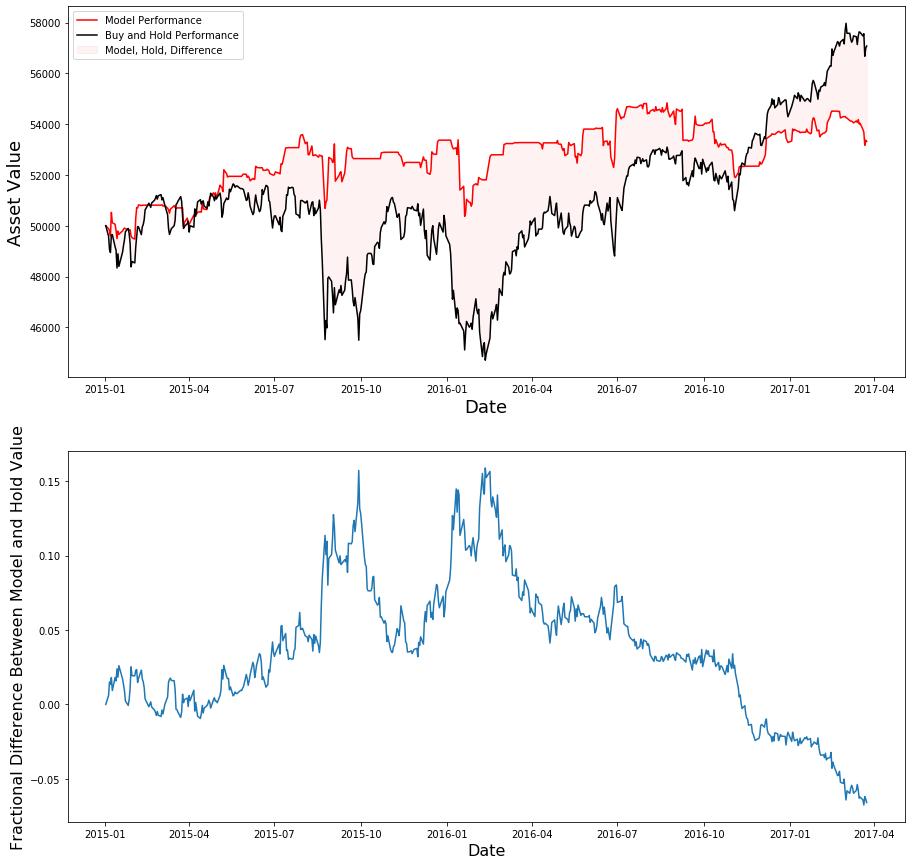

In [50]:
fig, ax = plt.subplots(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(model_performance['Date'],model_performance['Portfolio_Value'], label='Model Performance', c='red')
plt.xlabel("Date", size=18)
plt.ylabel('Asset Value', size=18)
plt.subplot(2,1,1)
plt.plot(model_performance['Date'],model_performance['hold_value'], label='Buy and Hold Performance', c='black')
plt.subplot(2,1,1)
plt.fill_between(model_performance['Date'], model_performance['Portfolio_Value'], model_performance['hold_value'], color='red', label='Model, Hold, Difference', alpha=0.05 )
plt.legend()
plt.subplot(2,1,2)
plt.plot(model_performance['Date'], (model_performance['Portfolio_Value'] - model_performance['hold_value'])/model_performance['hold_value'])
plt.xlabel('Date', size=16)
plt.ylabel('Fractional Difference Between Model and Hold Value', size=16)
plt.show()


In [51]:
years = np.round((model_performance['Date'].iloc[-1] - model_performance['Date'].iloc[0]).days/365.25,1)
model_ror = np.round(ror(model_performance['Portfolio_Value'].iloc[-1], model_performance['Portfolio_Value'].iloc[0], years),1)
hold_ror = np.round(ror(model_performance['hold_value'].iloc[-1], model_performance['hold_value'].iloc[0], years),1)
ror_improvement = np.round(((model_ror/hold_ror) -1) *100,1)

print('For the test period of 'f'{years} years from beginning of 2015 to early 2017,\na daily buy and sell strategy guided by our model would have a 'f'{model_ror} percent rate of return.\nFor the same time period, a buy and hold strategy would have had a 'f'{hold_ror} percent rate of return.\nThe model represents a 'f'{ror_improvement} percent improvement in rate of return over this time period.')

For the test period of 2.2 years from beginning of 2015 to early 2017,
a daily buy and sell strategy guided by our model would have a 3.0 percent rate of return.
For the same time period, a buy and hold strategy would have had a 6.2 percent rate of return.
The model represents a -51.6 percent improvement in rate of return over this time period.


The plot and our calculations show that our model substantially improved the rate of return from investing in the S&P500 index during the test time period.  If we look at the plots, it seems to do this, in general, by figuring out to sell before the market takes a dip, and so it is less impacted by those events.

There are instances where it makes wrong guesses and underperforms a buy and hold strategy. For example, the time period just before 2016-01, our model performance takes a large dip, compared to the relatively small one that the reference experiences. 

In order to see if we can reduce our risk and take more advantage of the information from the model, let's run this again using the confidence the model provides in it's label as a weighting factor for how much to buy.

In [52]:
confidence_scores = train_fit_model(logreg)[2].predict_proba(X_test)

The accuracy score for this model is 0.5045


In [53]:
conscore = pd.DataFrame(confidence_scores)
max_scores = conscore.max(axis=1)
norm_scores = ((max_scores-0.5)/(max_scores-0.5).max())
test_data['Norm Score'] = norm_scores
prediction_data = prediction_data.merge(test_data[['Date', 'Norm Score']], how='left', on='Date')


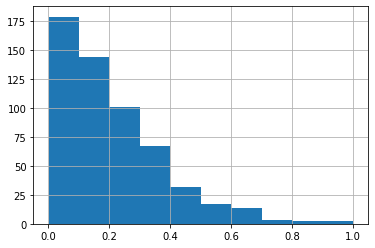

In [56]:
prediction_data['Norm Score'].hist()

Most of the confidence scores are pretty low, but if our model is smart, perhapys we can reduce fluctuations, and make it less likely that we lose money against the reference over short periods overall  by scaling our purchase based upon our confidence.

In [57]:
def buy_sell_scaled(column):
    funds = 50000
    stocks = 0
    chrono_data = prediction_data.sort_values('Date', ascending=True)
    values = []
#     return chrono_data['Buy or Sell'].value_counts()
    for index, row in chrono_data.iterrows():
        if row[column] == 'Buy':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_bought = math.floor(funds*(row['Norm Score']) / price)
            stocks = stocks + stocks_bought
            stock_value = stocks*price
            funds = funds - (price * stocks_bought)
            total_value = funds + stock_value
            values.append(total_value)
        if row[column] == 'Sell':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_sold = stocks*row['Norm Score']
            stocks = stocks - stocks_sold
            stock_value = stocks*price
            funds = funds +stocks_sold*price
            total_value = funds + stock_value
            values.append(total_value)
    date_list = chrono_data['Date'].tolist()
    portfolio_value = pd.DataFrame({'Date': date_list, 'Scaled Model Value': values})
    return portfolio_value

scaled_model = buy_sell_scaled('Buy or Sell Model')
scaled_model = scaled_model.merge(model_performance[['Date','hold_value', 'Portfolio_Value']], how='left', on='Date')

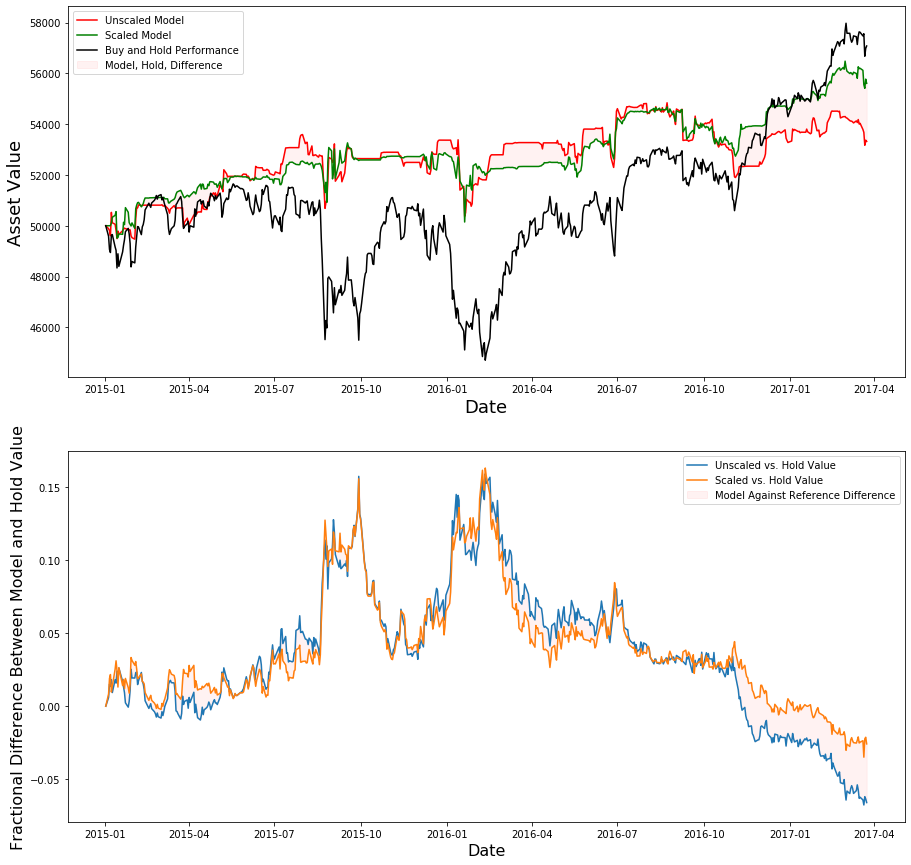

In [58]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,15))
ax1.plot(scaled_model['Date'],scaled_model['Portfolio_Value'], label='Unscaled Model', c='red')
ax1.set_xlabel("Date", size=18)
ax1.set_ylabel('Asset Value', size=18)
ax1.plot(scaled_model['Date'],scaled_model['Scaled Model Value'], label='Scaled Model', c='green')
ax1.plot(scaled_model['Date'],scaled_model['hold_value'], label='Buy and Hold Performance', c='black')
ax1.fill_between(scaled_model['Date'], scaled_model['Portfolio_Value'], scaled_model['Scaled Model Value'], color='red', label='Model, Hold, Difference', alpha=0.05 )
ax1.legend()
ax2.plot(scaled_model['Date'], (scaled_model['Portfolio_Value'] - scaled_model['hold_value'])/scaled_model['hold_value'], label='Unscaled vs. Hold Value')
ax2.plot(scaled_model['Date'], (scaled_model['Scaled Model Value'] - scaled_model['hold_value'])/scaled_model['hold_value'], label='Scaled vs. Hold Value')
ax2.fill_between(scaled_model['Date'], (scaled_model['Portfolio_Value'] - scaled_model['hold_value'])/scaled_model['hold_value'], (scaled_model['Scaled Model Value'] - scaled_model['hold_value'])/scaled_model['hold_value'], color='red', label='Model Against Reference Difference', alpha=0.05 )
ax2.set_xlabel('Date', size=16)
ax2.set_ylabel('Fractional Difference Between Model and Hold Value', size=16)
ax2.legend()
plt.show()


Scaling against out confidence does seem to smoothe out the curves somewhat, but since we are buying and selling so much less of our assets, we don't make as much money overall this way.

When we look at these charts, particularly the ones that show the difference against the buy and hold reference, we notice that the gains from our model are all nearly all in the first year, by avoiding the big downturns of the market.  After that, as the market picks up gradually, we start to lose ground against the reference.

This could be due to a couple of reasons.  Perhaps what our model tends to really excel at is selling off before a big downturn, and so we just mainly make money against the reference in times when those downturns occur.  A second reason could be that the model get's stale pretty quickly, after a year or so.  In that case, we would want to retrain our model periodicially to ensure it's performance remains at peak. 

We can investigate these issues by testing and training our datasets on different pieces of overall dataset.  While building this model, we did use 10x cross validation, so we expect it to work across time.

Finally, we have built and rebuilt a number of custom functions and dataframes with slight tweaks as our methodology changes.  Let's clean this up a bit and put it all into one se of functions to be able to test our model easily against different time periods.

In [59]:
def split_by_date(split_date,simul_days):
    target1 = 'Buy or Sell'
    train_data = model_data[model_data['Date'] < pd.to_datetime(split_date)].copy()
    if len(train_data) > 600:
        train_data = train_data.iloc[:-399]
    test_data = model_data[model_data['Date'] >= pd.to_datetime(split_date)].copy()
    if len(test_data) > simul_days:
        test_data = test_data.iloc[-simul_days:]
    X_train = train_data.drop(['Date', target1, target2, target3], axis=1)
    X_test = test_data.drop(['Date', target1, target2, target3], axis=1)
    y_train= train_data[target1]
    y_test= test_data[target1]
    return X_train, X_test, y_train, y_test, test_data
    
def train_fit_model(estimator=logreg, X_train=X_train, y_train=y_train1, X_test=X_test, y_test=y_test1):
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_test)
    score = accuracy_score(y_test, predictions)
    print('The accuracy score for this model is 'f'{round(score,4)}')
    return predictions

def buy_or_sell_test(data, frac=0.75):
    funds = 50000
    stocks = 0
    chrono_data = data.sort_values('Date', ascending=True)
    values = []
    for index, row in chrono_data.iterrows():
        if row['Model Buy or Sell'] == 'Buy':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_bought = math.floor(funds*(frac) / price)
            stocks = stocks + stocks_bought
            stock_value = stocks*price
            funds = funds - (price * stocks_bought)
            total_value = funds + stock_value
            values.append(total_value)
        if row['Model Buy or Sell'] == 'Sell':
            price = round(random.uniform(row['Low'], row['High']),2)
            stocks_sold = stocks*frac
            stocks = stocks - stocks_sold
            stock_value = stocks*price
            funds = funds +stocks_sold*price
            total_value = funds + stock_value
            values.append(total_value)
    date_list = chrono_data['Date'].tolist()
    portfolio_value = pd.DataFrame({'Date': date_list, 'Model Portfolio Value': values})
    return portfolio_value

def plot_model(model_performance):
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,15))
#     ax1.subplot(2,1,1)
    ax1.plot(model_performance['Date'],model_performance['Model Portfolio Value'], label='Model Portfolio Value', c='red')
#     ax1.subplot(2,1,1)
    ax1.plot(model_performance['Date'],model_performance['hold_value'], label=' Reference Buy and Hold Value', c='black')
#     ax1.subplot(2,1,1)
    ax1.fill_between(model_performance['Date'], model_performance['Model Portfolio Value'], model_performance['hold_value'], color='red', label='Model, Hold, Difference', alpha=0.05 )
    ax1.set_xlabel("Date", size=18)
    ax1.set_ylabel('Asset Value', size=18)
    ax1.legend()
#     ax2.subplot(2,1,2)
    ax2.plot(model_performance['Date'], (model_performance['Model Portfolio Value'] - model_performance['hold_value'])/model_performance['hold_value'])
    ax2.set_xlabel('Date', size=16)
    ax2.set_ylabel('Fractional Difference Between Model and Hold Value', size=16)
    plt.show()
    
def print_ror(model_performance):
    begin_date = model_performance['Date'].iloc[0]
    end_date = model_performance['Date'].iloc[-1]
    years = np.round((end_date - begin_date).days/365.25,1)
    model_ror = np.round(ror(model_performance['Model Portfolio Value'].iloc[-1], model_performance['Model Portfolio Value'].iloc[0], years),1)
    hold_ror = np.round(ror(model_performance['hold_value'].iloc[-1], model_performance['hold_value'].iloc[0], years),1)
    ror_improvement = np.round(((model_ror/hold_ror) -1) *100,1)
    print('For the test period of 'f'{years} years from beginning on 'f'{begin_date},\na daily buy and sell strategy guided by our model would have a 'f'{model_ror} percent rate of return.\nFor the same time period, a buy and hold strategy would have had a 'f'{hold_ror} percent rate of return.\nThe model represents a 'f'{ror_improvement} percent improvement in rate of return over this time period.')


def split_model_plot(split_date, simul_days=1250, frac=0.75):
    X_train, X_test, y_train, y_test, test_data = split_by_date(split_date, simul_days)
    predictions = train_fit_model(logreg, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
#     return len(test_data), len(predictions)
    test_data['Model Buy or Sell'] = predictions
    prediction_data = test_data[['Date', 'Model Buy or Sell']]
    prediction_data = prediction_data.merge(data[['Date','High','Low', 'Buy or Sell', 'Median']], how='left', on='Date')
    prediction_data['Price'] = np.round(random.uniform(prediction_data['Low'], prediction_data['High']),2)
    initial_purchase = math.floor(50000 / prediction_data['Price'].iloc[-1])
    remainder = 50000 - initial_purchase*(prediction_data['Price'].iloc[-1])
    prediction_data['hold_value'] = prediction_data['Price']*initial_purchase + remainder
    model_performance = buy_or_sell_test(prediction_data, frac=frac)
    model_performance = model_performance.merge(prediction_data[['Date','Buy or Sell','Model Buy or Sell','hold_value']], how='left', on='Date')
    print_ror(model_performance)
    plot_model(model_performance)


The accuracy score for this model is 0.5208
For the test period of 5.1 years from beginning on 1965-01-04 00:00:00,
a daily buy and sell strategy guided by our model would have a 2.3 percent rate of return.
For the same time period, a buy and hold strategy would have had a 0.3 percent rate of return.
The model represents a 666.7 percent improvement in rate of return over this time period.


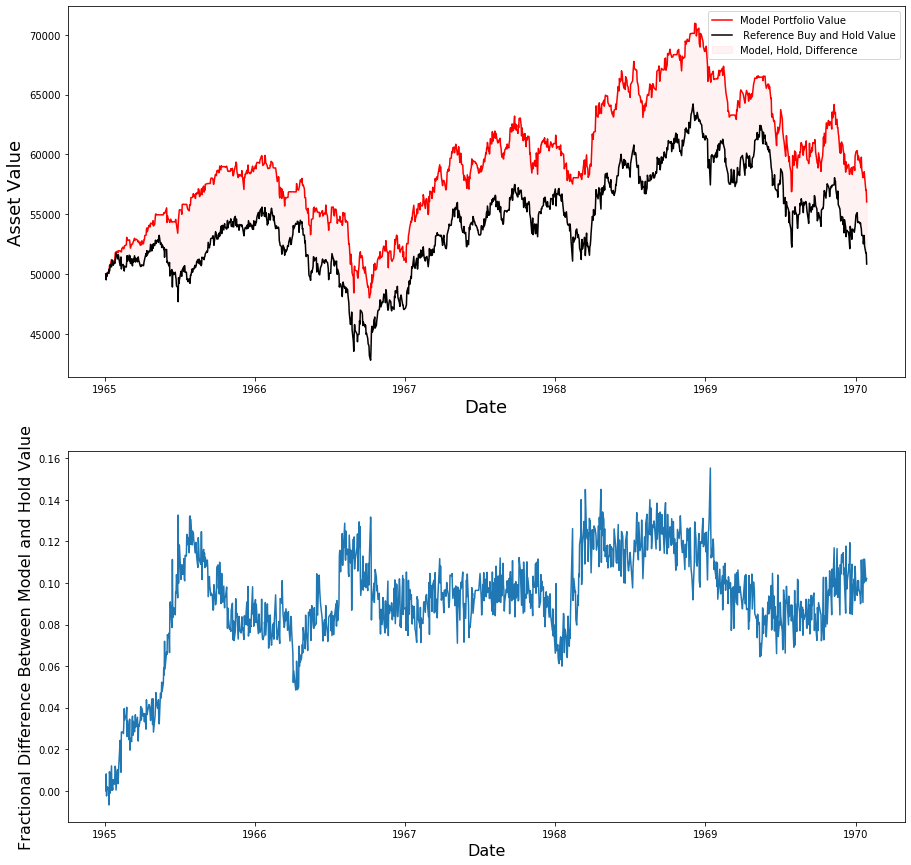

The accuracy score for this model is 0.5056
For the test period of 4.9 years from beginning on 1970-01-02 00:00:00,
a daily buy and sell strategy guided by our model would have a -0.8 percent rate of return.
For the same time period, a buy and hold strategy would have had a -5.9 percent rate of return.
The model represents a -86.4 percent improvement in rate of return over this time period.


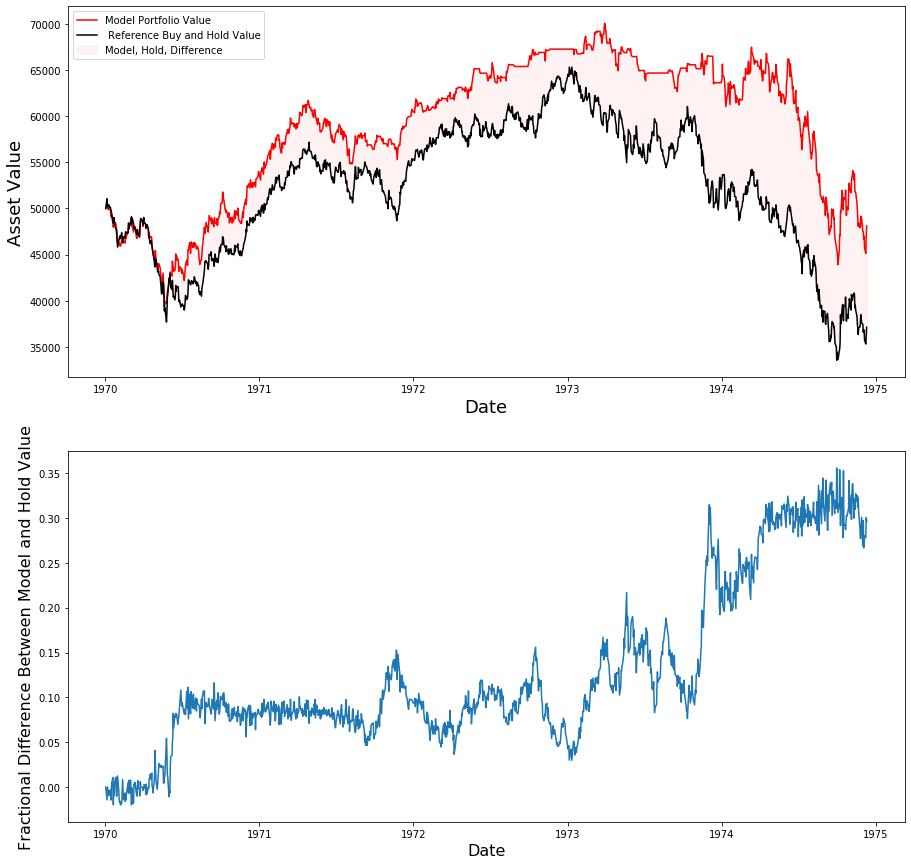

The accuracy score for this model is 0.5032
For the test period of 4.9 years from beginning on 1975-01-02 00:00:00,
a daily buy and sell strategy guided by our model would have a 9.3 percent rate of return.
For the same time period, a buy and hold strategy would have had a 9.4 percent rate of return.
The model represents a -1.1 percent improvement in rate of return over this time period.


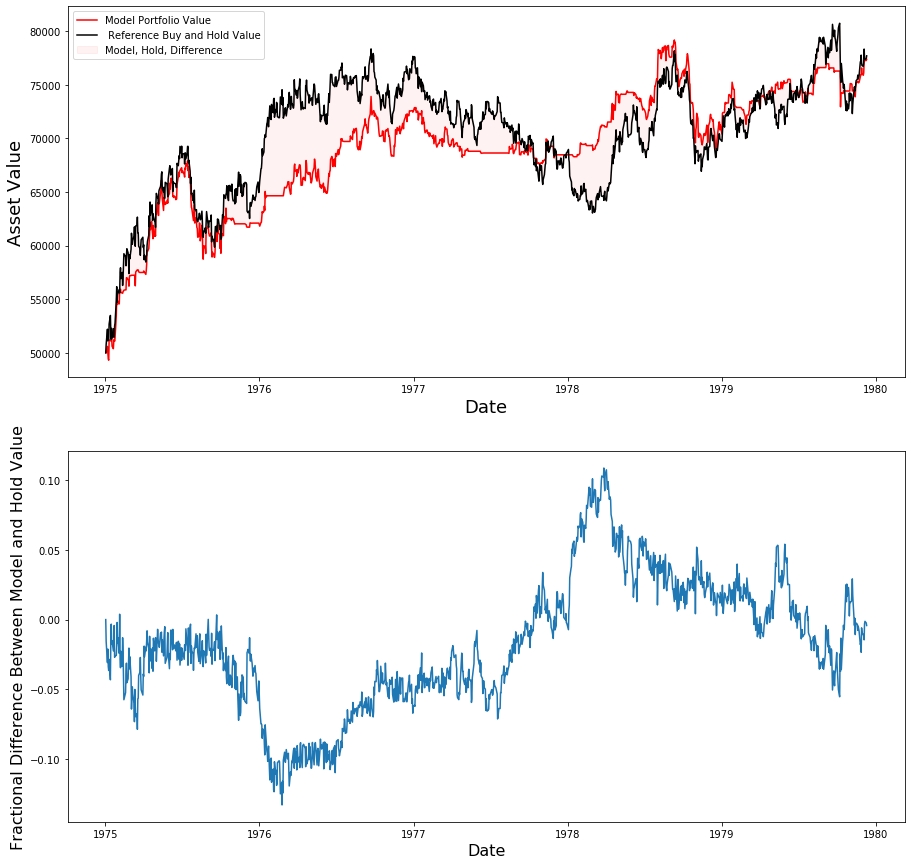

The accuracy score for this model is 0.5
For the test period of 4.9 years from beginning on 1980-01-02 00:00:00,
a daily buy and sell strategy guided by our model would have a 7.7 percent rate of return.
For the same time period, a buy and hold strategy would have had a 8.6 percent rate of return.
The model represents a -10.5 percent improvement in rate of return over this time period.


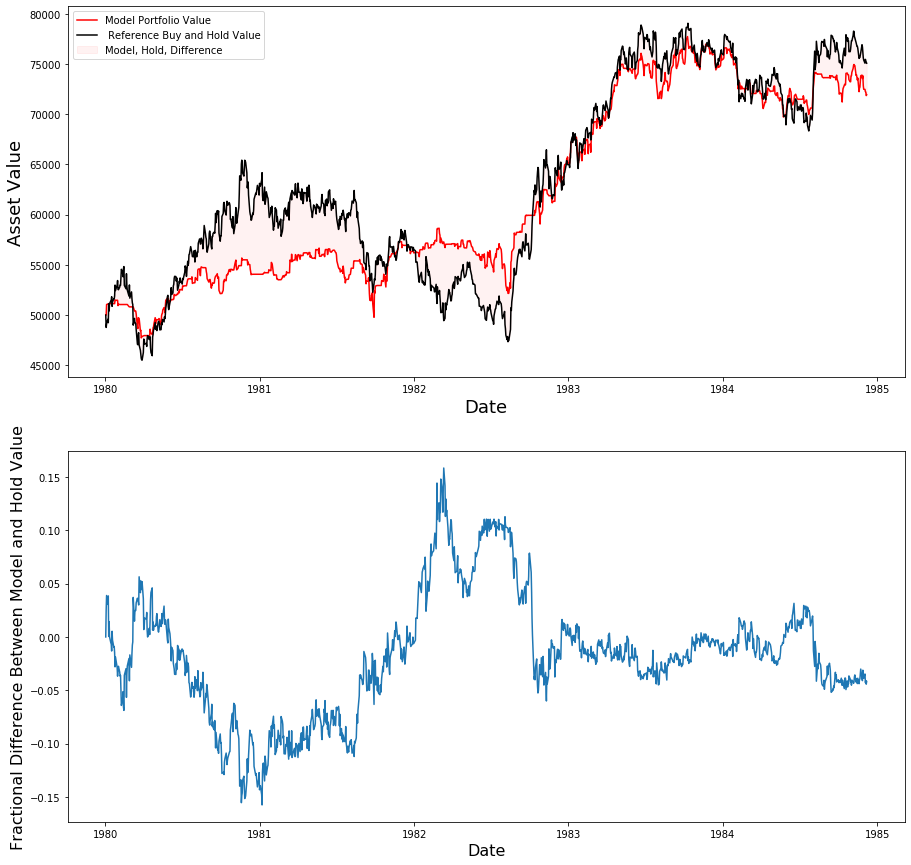

The accuracy score for this model is 0.5128
For the test period of 4.9 years from beginning on 1985-01-02 00:00:00,
a daily buy and sell strategy guided by our model would have a 10.7 percent rate of return.
For the same time period, a buy and hold strategy would have had a 16.1 percent rate of return.
The model represents a -33.5 percent improvement in rate of return over this time period.


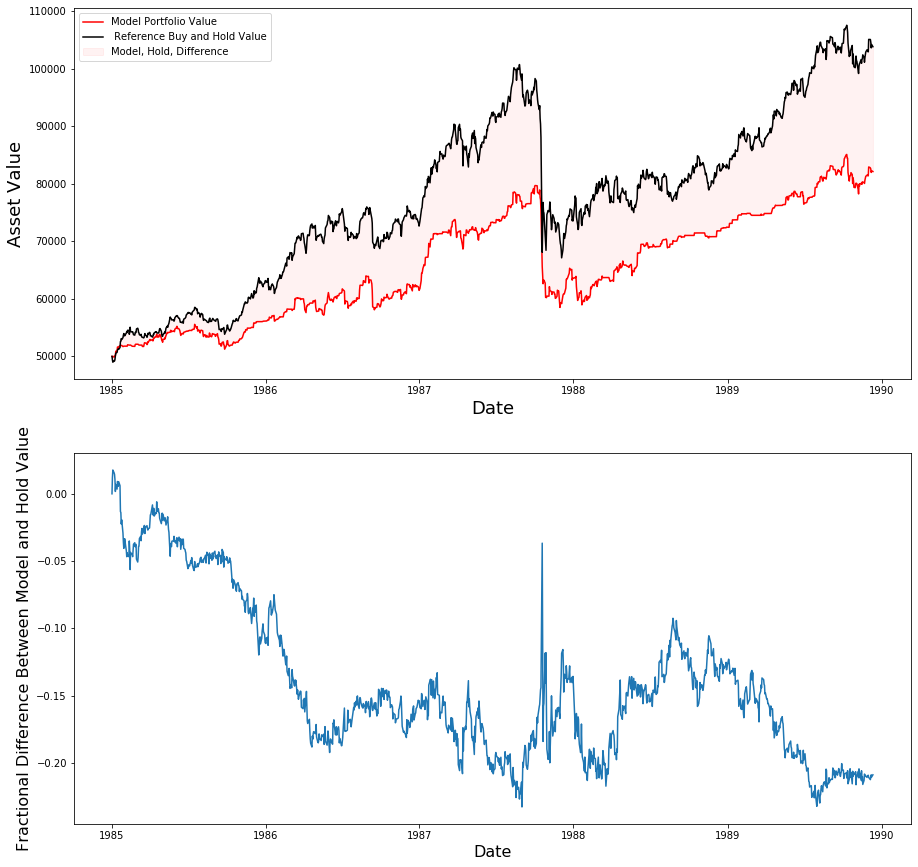

The accuracy score for this model is 0.5072
For the test period of 4.9 years from beginning on 1990-01-02 00:00:00,
a daily buy and sell strategy guided by our model would have a 2.1 percent rate of return.
For the same time period, a buy and hold strategy would have had a 4.8 percent rate of return.
The model represents a -56.2 percent improvement in rate of return over this time period.


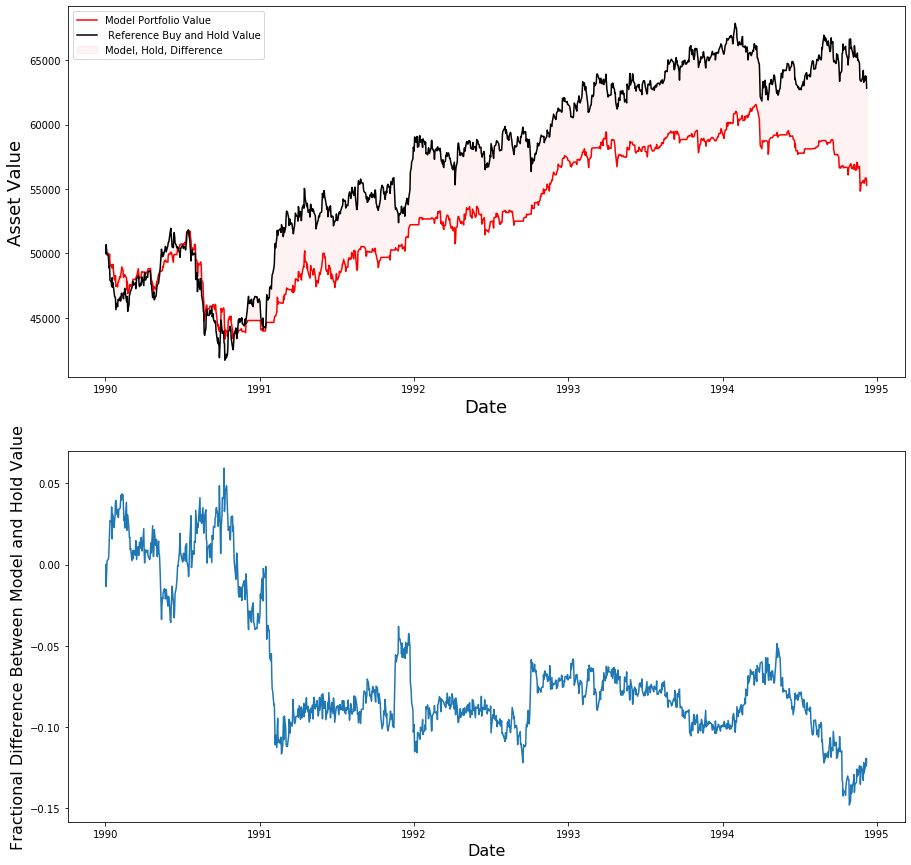

The accuracy score for this model is 0.504
For the test period of 4.9 years from beginning on 1995-01-03 00:00:00,
a daily buy and sell strategy guided by our model would have a 10.4 percent rate of return.
For the same time period, a buy and hold strategy would have had a 25.9 percent rate of return.
The model represents a -59.8 percent improvement in rate of return over this time period.


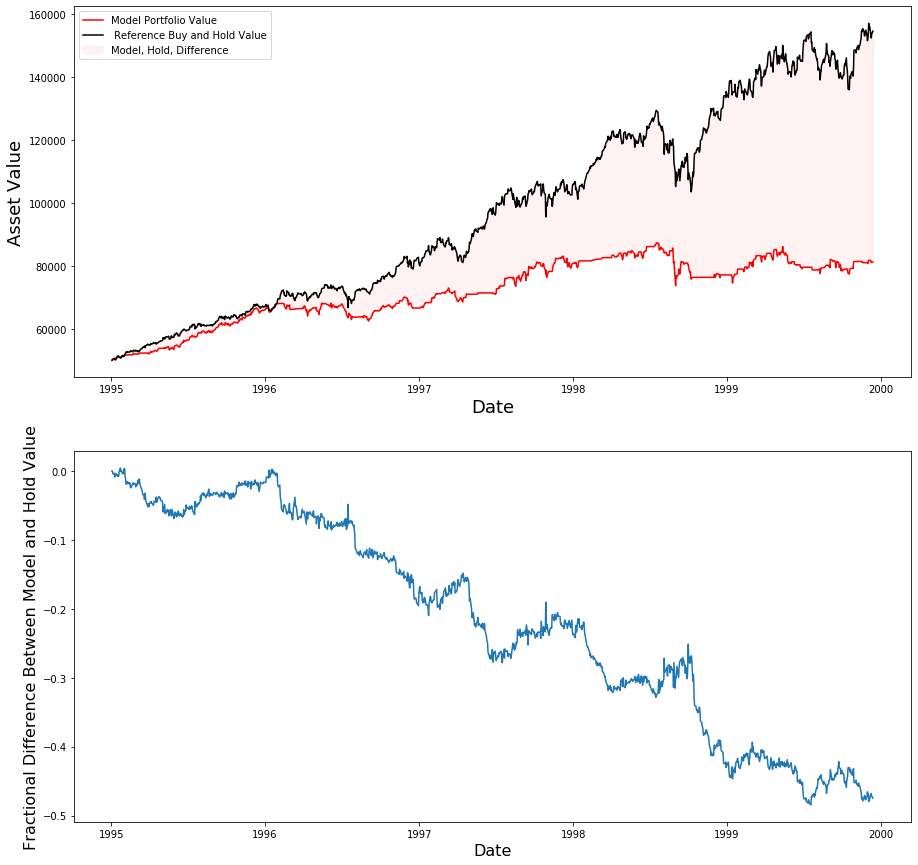

The accuracy score for this model is 0.5296
For the test period of 5.0 years from beginning on 2000-01-03 00:00:00,
a daily buy and sell strategy guided by our model would have a 4.1 percent rate of return.
For the same time period, a buy and hold strategy would have had a -3.5 percent rate of return.
The model represents a -217.1 percent improvement in rate of return over this time period.


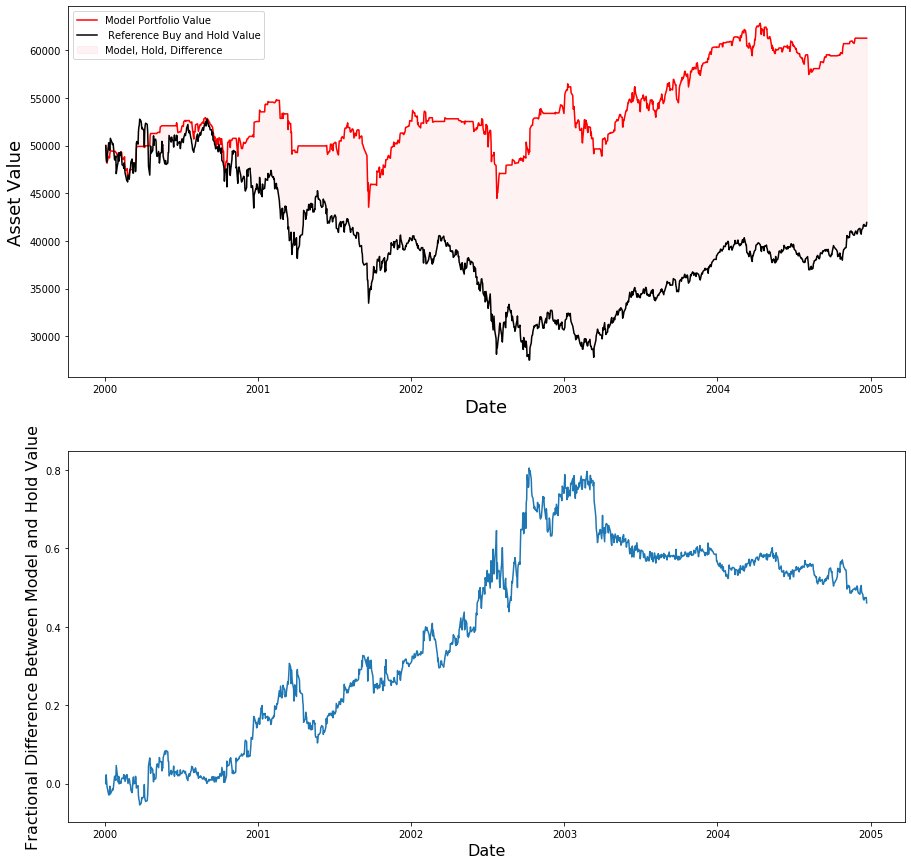

The accuracy score for this model is 0.528
For the test period of 5.0 years from beginning on 2005-01-03 00:00:00,
a daily buy and sell strategy guided by our model would have a 6.7 percent rate of return.
For the same time period, a buy and hold strategy would have had a -1.9 percent rate of return.
The model represents a -452.6 percent improvement in rate of return over this time period.


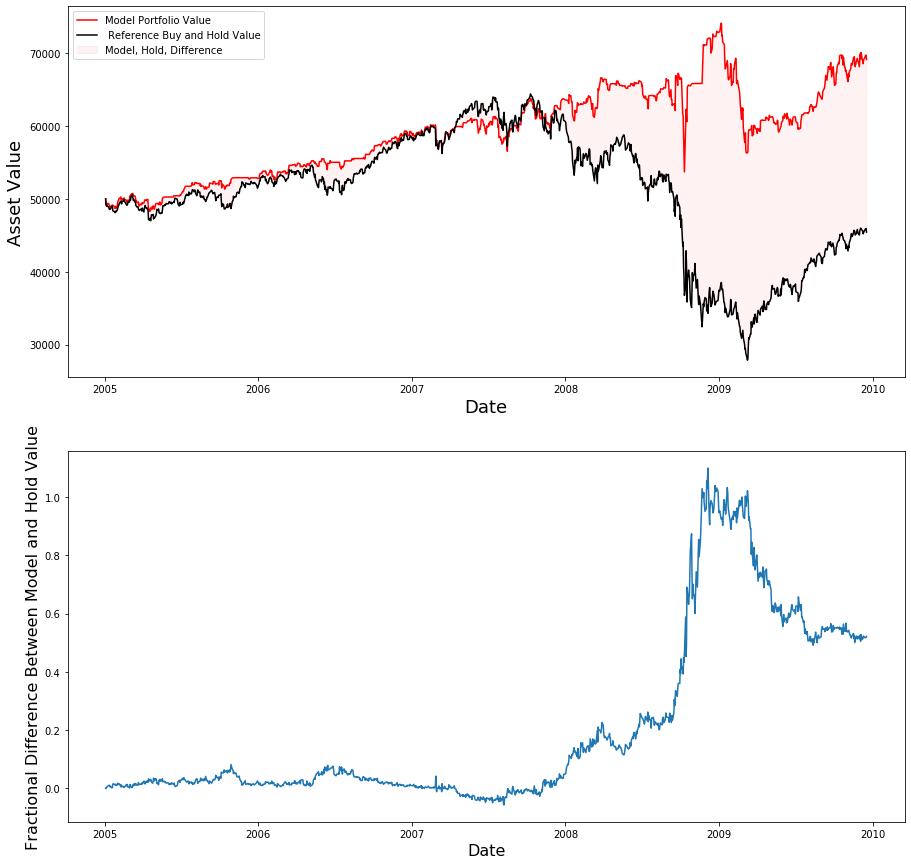

The accuracy score for this model is 0.5288
For the test period of 5.0 years from beginning on 2010-01-04 00:00:00,
a daily buy and sell strategy guided by our model would have a 13.2 percent rate of return.
For the same time period, a buy and hold strategy would have had a 12.3 percent rate of return.
The model represents a 7.3 percent improvement in rate of return over this time period.


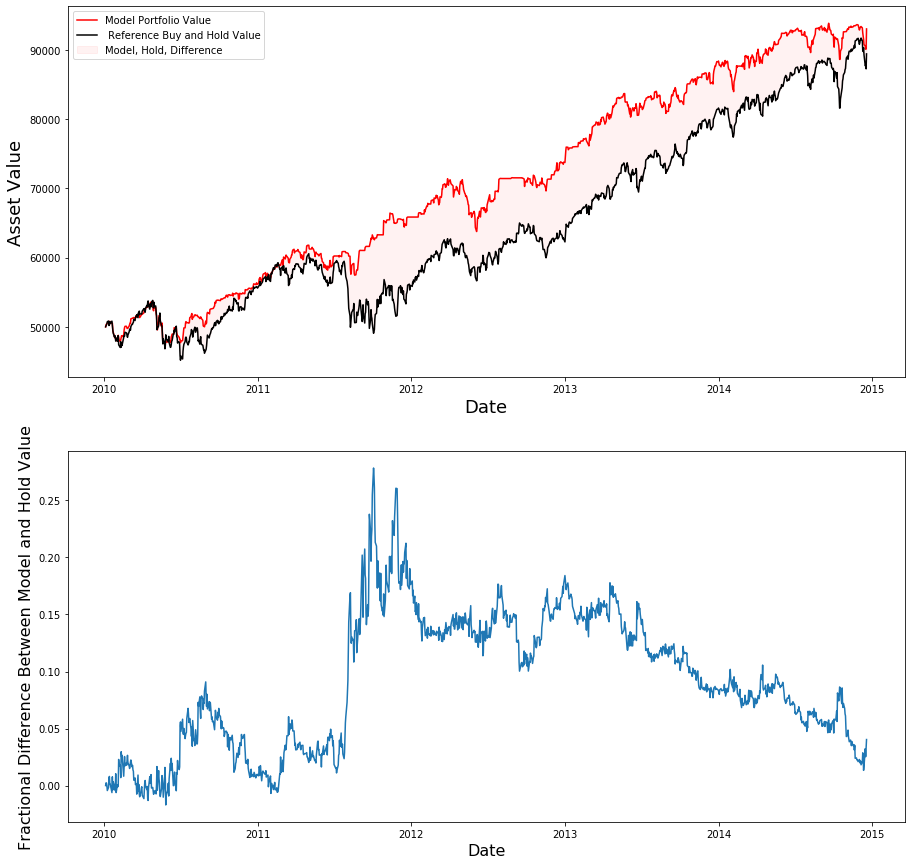

The accuracy score for this model is 0.5205
For the test period of 2.2 years from beginning on 2015-01-02 00:00:00,
a daily buy and sell strategy guided by our model would have a 9.6 percent rate of return.
For the same time period, a buy and hold strategy would have had a 6.0 percent rate of return.
The model represents a 60.0 percent improvement in rate of return over this time period.


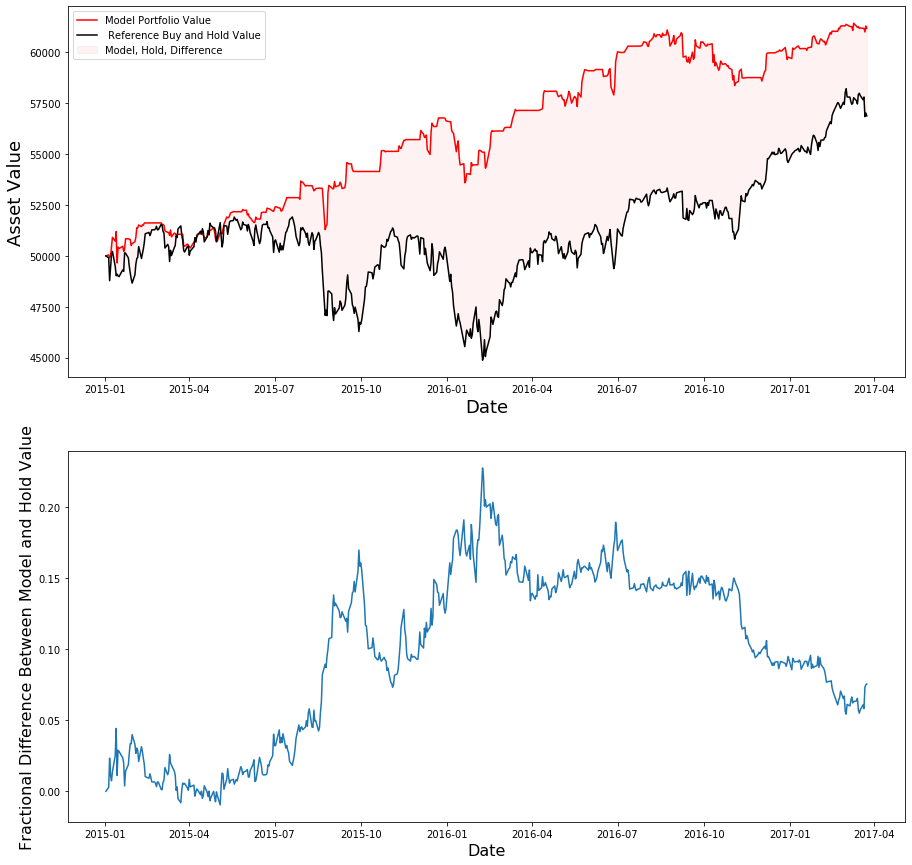

In [60]:
dates = ['1965-01-01','1970-01-01','1975-01-01','1980-01-01','1985-01-01', '1990-01-01','1995-01-01', '2000-01-01', '2005-01-01', '2010-01-01', '2015-01-01']
for i in dates:
    split_model_plot(i)

Our model would be an improvement for every five year window between 1965 and 2017.  If we look at time going on, the model doesn't actually appear to get stale after a year or so, but does seem to make the best improvements over reference when there is a market downturn, as can be seen around 1974, 1987, 2000, and 2008.  In effect, while this doesn't completely isolate the investor from recessions, it shows enormous improvement over market performance during those times.

One more thing worth checking, is how much our buy/sell fraction influcences our rate of return.  We arbitrarily set it at 75% so that we would always have the ability to make a sale or purchase, but that's not necessarily optimal.  We can quickly optimize it on recent data to see if it should be increased or reduced.

In [61]:
def train_fit_model(estimator=logreg, X_train=X_train, y_train=y_train1, X_test=X_test, y_test=y_test1):
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_test)
    score = accuracy_score(y_test, predictions)
    return predictions

def return_ror(model_performance):
    begin_date = model_performance['Date'].iloc[0]
    end_date = model_performance['Date'].iloc[-1]
    years = np.round((end_date - begin_date).days/365.25,1)
    model_ror = np.round(ror(model_performance['Model Portfolio Value'].iloc[-1], model_performance['Model Portfolio Value'].iloc[0], years),1)
    hold_ror = np.round(ror(model_performance['hold_value'].iloc[-1], model_performance['hold_value'].iloc[0], years),1)
    ror_improvement = np.round(((model_ror/hold_ror) -1) *100,1)
    return model_ror

def split_train_return(split_date, simul_days=1250, frac=0.75):
    X_train, X_test, y_train, y_test, test_data = split_by_date(split_date, simul_days)
    predictions = train_fit_model(logreg, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
#     return len(test_data), len(predictions)
    test_data['Model Buy or Sell'] = predictions
    prediction_data = test_data[['Date', 'Model Buy or Sell']]
    prediction_data = prediction_data.merge(data[['Date','High','Low', 'Buy or Sell', 'Median']], how='left', on='Date')
    prediction_data['Price'] = np.round(random.uniform(prediction_data['Low'], prediction_data['High']),2)
    initial_purchase = math.floor(50000 / prediction_data['Price'].iloc[-1])
    remainder = 50000 - initial_purchase*(prediction_data['Price'].iloc[-1])
    prediction_data['hold_value'] = prediction_data['Price']*initial_purchase + remainder
    model_performance = buy_or_sell_test(prediction_data, frac=frac)
    model_performance = model_performance.merge(prediction_data[['Date','Buy or Sell','Model Buy or Sell','hold_value']], how='left', on='Date')
    model_ror = return_ror(model_performance)
    return model_ror

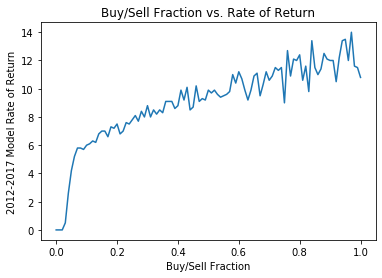

In [62]:
fracs = np.linspace(0,1,101)
rors = []
for i in fracs:
    rors.append(split_train_return('2012-01-01', 3000, frac=i))
    
plt.plot(fracs, rors)
plt.xlabel('Buy/Sell Fraction')
plt.ylabel('2012-2017 Model Rate of Return')
plt.title('Buy/Sell Fraction vs. Rate of Return')
plt.show()

We see a nearly mononotic increase with rate of return as we increase our buy/sell fraction.  This makes sense, mostly.  If we can beat the market, then we should try to play with as much money as we can.